### [2025_12_08]_과제
- 다양한 생선의 품종 식별 모델
- 데이터 : fish.csv
- 데이터 증강 : 160행 => (생선품종별로 갯수 동일하게 맞추기)
                     10K행
- 필수
   * 전처리
   * 타겟과 관련성 높은 피쳐 선택
   * 모델: KNN
   * 교차 검증 진행
   * 예측에 따른 확인 작업 필수

[1] 모듈 로딩 및 데이터 준비 <hr>

In [15]:
## 모듈 로딩
#-> 기본 모듈
import numpy as np
import pandas as pd

#-> 시각화 모듈
import matplotlib.pyplot as plt
import koreanize_matplotlib

#-> ML 관련 모듈
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [8]:
## 데이터 준비
DATA_FILE = '../Data/fish_train_10500.csv'

df = pd.read_csv(DATA_FILE)
df.Species.unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [9]:
df.head()

,Weight,Length,Diagonal,Height,Width,Species
0,487.423341,32.423746,37.857082,14.591014,5.270922,Bream
1,990.896538,41.365270,47.308866,18.719116,7.000605,Bream
2,627.081718,33.444702,38.939902,15.463397,5.670238,Bream
3,749.382720,35.686411,41.026632,15.974293,6.036774,Bream
4,615.621949,33.527752,39.005218,15.502285,5.483102,Bream


[2] 데이터 전처리 및 학습 준비 <hr>

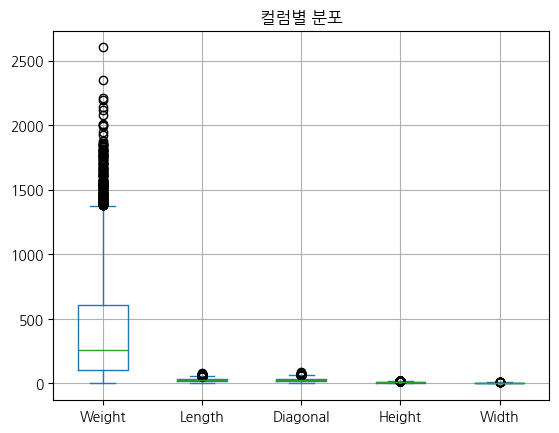

In [18]:
## -----------------------------------------
## 결측치/중복값/이상치
## -----------------------------------------
df.isna().sum()         ## => 0개

df.duplicated().sum()   ## => 0개

df.plot(kind='box', title='컬럼별 분포', grid=True)
plt.show()

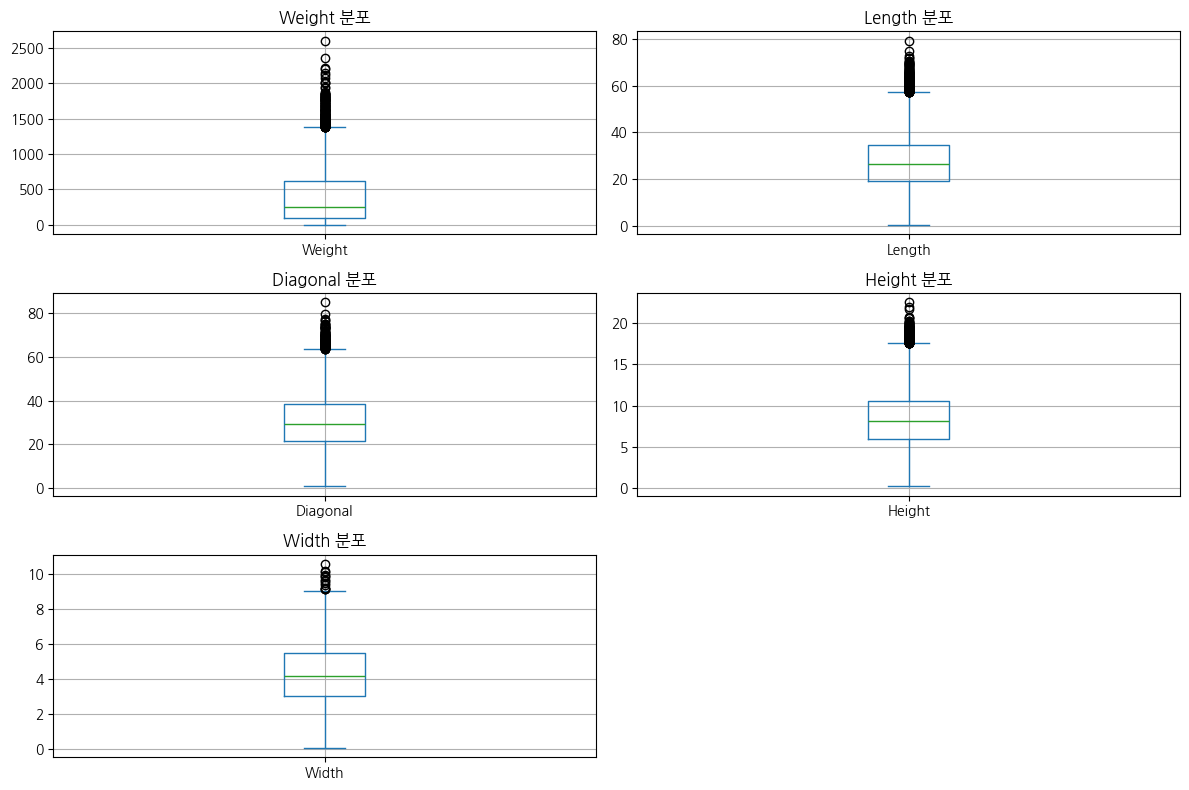

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

df[['Weight']].plot(kind='box', ax=axes[0, 0], grid=True)
axes[0, 0].set_title('Weight 분포')

df[['Length']].plot(kind='box', ax=axes[0, 1], grid=True)
axes[0, 1].set_title('Length 분포')

df[['Diagonal']].plot(kind='box', ax=axes[1, 0], grid=True)
axes[1, 0].set_title('Diagonal 분포')

df[['Height']].plot(kind='box', ax=axes[1, 1], grid=True)
axes[1, 1].set_title('Height 분포')

df[['Width']].plot(kind='box', ax=axes[2, 0], grid=True)
axes[2, 0].set_title('Width 분포')

axes[2, 1].set_visible(False)  # 마지막 칸 비우기

plt.tight_layout()
plt.show()

In [ ]:
## 이상치 제거 함수
def delete_iqr(c_name):
    q1 = c_name.quantile(.25)
    q3 = c_name.quantile(.75)
    iqr = q3 - q1

    cond = (c_name >= (q1-iqr*1.5)) & (c_name <= (q3+iqr*1.5))
    c_name = c_name(cond)

In [7]:
## [2-1] 품종컬럼 자료형 변환
pd.options.mode.copy_on_write = True

df.Species = df.Species.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Species   159 non-null    category
 1   Weight    159 non-null    float64 
 2   Length    159 non-null    float64 
 3   Diagonal  159 non-null    float64 
 4   Height    159 non-null    float64 
 5   Width     159 non-null    float64 
dtypes: category(1), float64(5)
memory usage: 6.8 KB


In [11]:
## [2-2] 피쳐와 타겟분리
featureDF = df[ df.columns[:-1] ]
targetSR  = df[ df.columns[-1]  ]

print(f'featureDF : {featureDF.shape},  targetSR : {targetSR.shape}')

featureDF : (10500, 5),  targetSR : (10500,)


In [ ]:
## [2-3] 수치형 컬럼 => KNN 알고리즘 : 스케일링
